# Learning outcomes
- Method to quantize / measure the image segmentation model: Intersection over Union (IOU).
- Imgae gradients associate closely with edges. Edge detections
    * Sobel
    * Scharr
    * Laplacian
    * Canny
- Contour detection (`cv.findContour()`)
- Contour features (bounding box, perimeter, area, centroid) as well as properties (aspect ratio, circularity, solidity and extent)
- Built-in method for blob detection
    - Blob is a connected components in an image with similar brightness or intensity value.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

In [1]:
!pip install requests

                                              0.0/62.6 kB ? eta -:--:--
     ---------------------------------------- 62.6/62.6 kB 3.3 MB/s eta 0:00:00
                                              0.0/96.6 kB ? eta -:--:--
     ---------------------------------------- 96.6/96.6 kB 5.4 MB/s eta 0:00:00
                                              0.0/123.9 kB ? eta -:--:--
     ---------------------------------------- 123.9/123.9 kB ? eta 0:00:00
                                              0.0/158.3 kB ? eta -:--:--
     -------------------------------------- 158.3/158.3 kB 9.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: C:\Users\user\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


## IOU
Formula:

$$IOU = \frac{[A \cap B]}{[A \cup B]}$$

In [14]:
## function to compute IOU
def computeIOU(boxA, boxB):
    """Args:
    boxA: ground truth
    boxB: prediction   They are lists of points"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    # compute the intersection area
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1)
    
    # area of box A and box B
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea / (areaA + areaB - interArea)

In [15]:
img = cv.imread("images/lena.jfif")

In [24]:
boxes = cv.selectROIs("bounding box", img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

In [25]:
boxes

array([[200,  27,  13,  18],
       [201,  28,  12,  19]])

In [26]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[0] + box[2], box[1] + box[3]]

In [27]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 2)
cv.rectangle(img_copy, (pred[0], pred[1]), (pred[2], pred[3]), (0, 0, 255), 2)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25), cv.FONT_HERSHEY_PLAIN, 0.5, (0, 255, 0), 1)
show_img("IOU", img_copy)

## Image gradients
kernel for $3 \times 3$ Sobel operatorsL

Vertical direction gradient (x-gradient)
$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

### Pitfalls (bit depth)

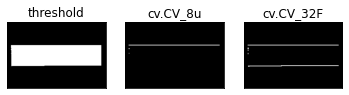

In [31]:
img = cv.imread("images/wood_planck.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# apply sobel kernel (wrong way)
sobely_8u = cv.Sobel(th, cv.CV_8U, 0, 1, ksize=3)

# right way
sobely_32f = cv.Sobel(th, cv.CV_32F, 0, 1, ksize=3)
sobely = cv.convertScaleAbs(sobely_32f)

plt.subplot(131), plt_img(th, "threshold")
plt.subplot(132), plt_img(sobely_8u, "cv.CV_8u")
plt.subplot(133), plt_img(sobely, "cv.CV_32F")
plt.show()

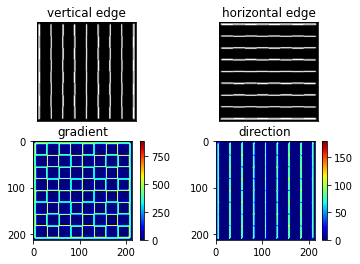

In [38]:
# combine both the x and y direction to form gradient and orientation map
img = cv.imread("images/chessboard.png", 0)

#sobel x and sobel y
sobelx = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely_8u = cv.convertScaleAbs(sobely)

# combine x and y
gradient = cv.magnitude(sobelx, sobely)
direction = np.arctan2(sobelx, sobely) * (180 / np.pi) % 180

plt.subplot(221), plt_img(sobelx_8u, "vertical edge")
plt.subplot(222), plt_img(sobely_8u, "horizontal edge")
plt.subplot(223), plt.imshow(gradient, cmap="jet"), plt.title("gradient"), plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap="jet"), plt.title("direction"), plt.colorbar()

plt.show()

## Laplacian (second order derivatives)

In [16]:
img = cv.imread("images/lena.jfif", 0)

#blur
blur = cv.GaussianBlur(img, (5, 5), 0)
LoG = cv.Laplacian(blur, cv.CV_16S)
LoG = cv.convertScaleAbs(LoG)

cv.imshow("grayscale", img)
show_img("LoG", LoG)

## Canny edge detector
- lower the number of false positives, enhance the edge detection accuracy.
- Flexible

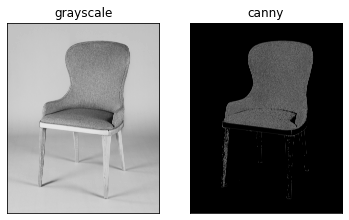

In [39]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

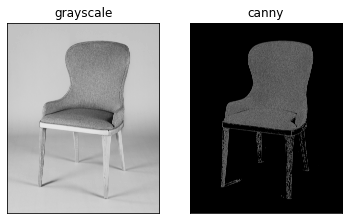

In [47]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 30, 150)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "canny")
plt.show()

In [50]:
#Exercise
# Create a trackbar that control the hysterisis thresholds and display the resulting images from the changes in the thresholds.

img = cv.imread("images/boat.jpg")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

wn = "Canny edge"
trackbarName = "low Threshold"
ratio = 2.5
img_copy = img.copy()
ksize = 3

def cannyThresh(val):
    edge = cv.Canny(gray, val, ratio * val, apertureSize = ksize)
    # creae color edge
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbarName, wn, 0, 100, cannyThresh)

cv.waitKey(0)
cv.destroyAllWindows()

In [34]:
# automatic Canny
def canny_auto(img, method, sigma=0.33):
    """Args:
     img: grayscale
     method: median, triangle and otsu
     sigma=0.33 (default)"""
    if method == "median":
        Th = np.median(img)
        
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
        
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    else:
        raise Exception("method specified not available!")
        
    lowThresh = (1-sigma) * Th
    highThresh = (1+sigma) * Th
    
    return cv.Canny(img, lowThresh, highThresh)
     

## Contours
- Curve joining all the points along the object boundary.

In [21]:
rect = np.zeros((256, 256), dtype = np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [22]:
len(contours)

1

In [23]:
contours[0]

array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32)

In [24]:
rect_bgr = cv.cvtColor(rect, cv.COLOR_GRAY2BGR)
cv.drawContours(rect_bgr, contours, -1, (0, 255, 0), 2)

show_img("contour", rect_bgr)

In [38]:
img = cv.imread("images/monitor.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Binary Threshold
th = cv.threshold(gray, 200, 255, cv.THRESH_BINARY_INV)[1]

# find contours
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# draw contours
img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 1)

show_img("contours", img_copy)

In [83]:
len(contours)

12

In [26]:
# one of the simple way: retain just the contour with largest number of points
length = [len(c) for c in contours]
cnt = contours[np.argmax(length)]

img_copy = img.copy()
cv.drawContours(img_copy, [cnt], -1, (0, 255, 0), 1)

show_img("contours", img_copy)

## Contour freatures
- centroid
- area
- perimeter
- bounding box

In [28]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [29]:
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

print(f"The centroid of contour: {cx, cy}")

The centroid of contour: (105, 103)


In [30]:
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)
print(f"The area of contour: {area}")
print("The perimeter of contour: {}". format(round(peri, 3)))

The area of contour: 37113.5
The perimeter of contour: 1056.777


## contour properties
$$aspect \ ratio = \frac{width}{height}$$

$$circularity = \frac{4 \times \pi \times A}{Perimeter^2}$$

In [31]:
img = cv.imread("images/remote-controller.webp")

show_img("aircond controller", img)

In [35]:
# resize -> grayscale -> bilateral -> Canny -> findContour -> Contour features
# sort the contour with respect to area in descending order
factor = 200 / img.shape[1]
img = cv.resize(img, None, fx=factor, fy=factor)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.bilateralFilter(gray, 7, 19, 13)
edge = canny_auto(blur, method="triangle")

show_img("edges", edge)

In [36]:
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

cnts = sorted(contours, key = cv.contourArea, reverse=True)[:5]
screen = None
img_copy = img.copy()

#rectangular contour
for c in cnts:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        screen = c
        break

cv.drawContours(img_copy, [screen], -1, (0, 255, 0), 2)
show_img("contour", img_copy)

In [100]:
# define the low and high threshold for red color in HSV color space
redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam is detected!")

kernel = np.ones((3,3), dtype=np.uint8)
fixed_width = min_area = 500
factor = fixed_width / cap.get(3)   #frame width

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("frame not received!")
        break
    
    # resize -> blur -> change to HSV -> color inRange -> morphology
    resize = cv.resize(frame, None, fx=factor, fy=factor)
    blur = cv.GaussiaBlur(resize, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    # color segmentation
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    
    # morphological opening (remove noise)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations = 2)
    
    # find contour
    contours = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = contours[0]
    
    # filter out the smaller object and draw bounding box
    for c in cnts:
        area = cv.contourArea(c)
        if area > min_area:
            bb = cv.boundingRect(c)
            bbs.append(bb)
    
    for bb in bbs:
        x, y, w, h = bb
        cv.rectangle(resize, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    cv.imshow("red object", resize)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()
cap.release()

SystemExit: No webcam is detected!

C:\Users\fict\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Weekly Exercise

In [ ]:
# Question 1
# Apply Sobel edge detection
# Load the image in grayscale
img = cv.imread("images/pineapple.jfif", 0)
blur = cv.GaussianBlur(img, (5, 5), 0)

# Sobel x and Sobel y
sobelx = cv.Sobel(blur, cv.CV_32F, 1, 0)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(blur, cv.CV_32F, 0, 1)
sobely_8u = cv.convertScaleAbs(sobely)
img_sobel = sobelx_8u + sobely_8u

# Apply Laplacian edge detection
LoG = cv.Laplacian(blur, cv.CV_16S)
laplacian_edge = cv.convertScaleAbs(LoG)

# Apply Prewitt edge detection
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv.filter2D(blur, -1, kernelx)
img_prewitty = cv.filter2D(blur, -1, kernely)

# Apply Scharr edge detection
scharr_X = cv.Scharr(blur, cv.CV_64F, 1, 0) 
scharr_X_abs = np.uint8(np.absolute(scharr_X)) 
scharr_Y = cv.Scharr(blur, cv.CV_64F, 0, 1) 
scharr_Y_abs = np.uint8(np.absolute(scharr_Y)) 
scharr_XY_combined = cv.bitwise_or(scharr_Y_abs,scharr_X_abs) 

# Apply Canny edge detection
canny_edge = cv.Canny(blur, threshold1=100, threshold2=200)

# Display the results
cv.imshow('Sobel Edge Detection', img_sobel)
cv.imshow('Laplacian Edge Detection', laplacian_edge)
cv.imshow('Prewitt Edge Detection', img_prewittx + img_prewitty)
cv.imshow('Scharr Edge Detection', scharr_XY_combined)
cv.imshow('Canny Edge Detection', canny_edge)

cv.waitKey(0)
cv.destroyAllWindows()

#Sobel: Sobel can detect the edge of the object and it also detect the cloud at behind
#Laplacian: Laplacian detected the edge of the pineapple and the grass on the ground
#Prewitt: Prewitt can detect the edge of the object with a smooth line
#Scharr: Scharr detected the pineapple, grass, and cloud with a lot of white point
#Canny: Canny have a better detection to the pineapple with a simple line.

In [4]:
# Question 2
# Load the image
image = cv.imread('images/electronic.jfif')

# Convert the image to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply thresholding to segment white regions
ret, thresh = cv.threshold(gray, 200, 255, cv.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Filter out small contours
min_contour_area = 500
filtered_contours = [cnt for cnt in contours if cv.contourArea(cnt) > min_contour_area]

# Draw bounding boxes around white objects
for cnt in filtered_contours:
    x, y, w, h = cv.boundingRect(cnt)
    cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes
cv.imshow('White Objects with Bounding Boxes', image)
cv.waitKey(0)
cv.destroyAllWindows()

In [3]:
# Question 3
# Load the image
image = cv.imread('images/clock.jpg')

# Convert the image to grayscale
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv.Canny(gray, threshold1=30, threshold2=70)

# Find contours in the edge-detected image
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Identify the clock contour based on area and aspect ratio
clock_contour = None
max_area = 0
min_aspect_ratio = 0.7
max_aspect_ratio = 1.3

for contour in contours:
    area = cv.contourArea(contour)
    x, y, w, h = cv.boundingRect(contour)
    aspect_ratio = w / float(h) if h != 0 else 0

    if max_aspect_ratio > aspect_ratio > min_aspect_ratio and area > max_area:
        max_area = area
        clock_contour = contour

if clock_contour is not None:
    # Get the minimum enclosing circle around the clock contour
    (x, y), radius = cv.minEnclosingCircle(clock_contour)
    center = (int(x), int(y))
    radius = int(radius)

    # Draw the bounding circle
    cv.circle(image, center, radius, (0, 255, 0), 2)

# Display the image with the bounding circle
cv.imshow('Clock with Bounding Circle', image)
cv.waitKey(0)
cv.destroyAllWindows()